In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os
import keras
from keras_unet.models import custom_unet

Populating the interactive namespace from numpy and matplotlib


2023-03-31 21:51:31.468035: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [3]:
images = np.load(images_file)
labels = np.load(labels_file)

In [4]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [5]:
p = np.random.permutation(len(images))

In [6]:
images = images[p]
labels = labels[p]

In [7]:
labels = labels.astype(np.float64)

In [8]:
images = images.astype(np.float64)

for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [9]:
images.shape, labels.shape

((766, 512, 512, 1), (766, 512, 512, 1))

In [10]:
import json

In [11]:
with open("image_data_v3.json", "r") as fp:
    image_data = json.load(fp)
with open("label_data_v3.json", "r") as fp:
    label_data = json.load(fp)

In [12]:
X_train = images[0:image_data['82']]
y_train = labels[0:label_data['82']]
X_val = images[image_data['82']:]
y_val = labels[label_data['82']:]

In [13]:
model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=32, #64
    dropout=0.2,
    dropout_change_per_layer=0.0,
    num_layers=2,
    output_activation='sigmoid')

2023-03-31 21:51:33.889437: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-03-31 21:51:34.024583: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-03-31 21:51:34.027224: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-03-31 21:51:34.027243: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-03-31 21:51:34.030118: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-31 

In [14]:
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from tensorflow.keras.optimizers import Adam, SGD

In [15]:
model.compile(optimizer = Adam(learning_rate=0.001),
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

In [16]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=32,
                    epochs=200,
                    validation_data=(X_val, y_val))

2023-03-31 21:51:36.468621: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-31 21:51:36.489178: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/200


2023-03-31 21:51:37.349191: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-03-31 21:51:37.957649: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-03-31 21:51:38.610069: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-03-31 21:51:38.610096: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-03-31 21:51:38.610172: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-03-31 21:51:38.690778: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-31 21:51:39.397173: I tensorflow/stream_exec

19/19 [==============================] - 18s 536ms/step - loss: 0.1615 - iou: 9.4152e-05 - iou_thresholded: 2.8127e-04 - val_loss: 0.0237 - val_iou: 1.3390e-05 - val_iou_thresholded: 4.0422e-04
Epoch 2/200
19/19 [==============================] - 5s 272ms/step - loss: 0.0206 - iou: 1.1078e-04 - iou_thresholded: 2.7164e-04 - val_loss: 0.0066 - val_iou: 8.6168e-05 - val_iou_thresholded: 4.0422e-04
Epoch 3/200
19/19 [==============================] - 5s 271ms/step - loss: 0.0066 - iou: 2.2585e-04 - iou_thresholded: 2.5437e-04 - val_loss: 0.0074 - val_iou: 6.4920e-04 - val_iou_thresholded: 4.0422e-04
Epoch 4/200
19/19 [==============================] - 5s 270ms/step - loss: 0.0054 - iou: 4.2961e-04 - iou_thresholded: 2.6015e-04 - val_loss: 0.0054 - val_iou: 6.2177e-04 - val_iou_thresholded: 4.0422e-04
Epoch 5/200
19/19 [==============================] - 5s 270ms/step - loss: 0.0050 - iou: 4.5495e-04 - iou_thresholded: 2.7983e-04 - val_loss: 0.0056 - val_iou: 7.0192e-04 - val_iou_thresholde

19/19 [==============================] - 5s 269ms/step - loss: -0.0016 - iou: 0.1948 - iou_thresholded: 0.2412 - val_loss: 9.3901e-04 - val_iou: 0.3047 - val_iou_thresholded: 0.3352
Epoch 44/200
19/19 [==============================] - 5s 271ms/step - loss: 0.0608 - iou: 0.0596 - iou_thresholded: 0.0826 - val_loss: 0.0166 - val_iou: 4.0418e-04 - val_iou_thresholded: 4.0422e-04
Epoch 45/200
19/19 [==============================] - 5s 268ms/step - loss: 0.0459 - iou: 4.8646e-04 - iou_thresholded: 2.6879e-04 - val_loss: 0.0041 - val_iou: 6.9148e-04 - val_iou_thresholded: 4.0422e-04
Epoch 46/200
19/19 [==============================] - 5s 268ms/step - loss: 0.0054 - iou: 7.6766e-04 - iou_thresholded: 2.5661e-04 - val_loss: 0.0029 - val_iou: 0.0017 - val_iou_thresholded: 4.0422e-04
Epoch 47/200
19/19 [==============================] - 5s 268ms/step - loss: 0.0039 - iou: 0.0014 - iou_thresholded: 2.5754e-04 - val_loss: 0.0027 - val_iou: 0.0023 - val_iou_thresholded: 4.0422e-04
Epoch 48/200
1

19/19 [==============================] - 5s 268ms/step - loss: 0.0026 - iou: 0.0260 - iou_thresholded: 8.0592e-04 - val_loss: 0.0019 - val_iou: 0.0424 - val_iou_thresholded: 0.0032
Epoch 86/200
19/19 [==============================] - 5s 274ms/step - loss: 0.0025 - iou: 0.0372 - iou_thresholded: 0.0050 - val_loss: 0.0018 - val_iou: 0.0506 - val_iou_thresholded: 0.0231
Epoch 87/200
19/19 [==============================] - 5s 280ms/step - loss: 0.0023 - iou: 0.0478 - iou_thresholded: 0.0173 - val_loss: 0.0016 - val_iou: 0.0749 - val_iou_thresholded: 0.0438
Epoch 88/200
19/19 [==============================] - 5s 270ms/step - loss: 0.0022 - iou: 0.0606 - iou_thresholded: 0.0244 - val_loss: 0.0015 - val_iou: 0.0854 - val_iou_thresholded: 0.0888
Epoch 89/200
19/19 [==============================] - 5s 268ms/step - loss: 0.0021 - iou: 0.0709 - iou_thresholded: 0.0490 - val_loss: 0.0015 - val_iou: 0.0998 - val_iou_thresholded: 0.1237
Epoch 90/200
19/19 [==============================] - 5s 26

Epoch 128/200
19/19 [==============================] - 5s 268ms/step - loss: 0.0014 - iou: 0.2326 - iou_thresholded: 0.3345 - val_loss: 0.0015 - val_iou: 0.2170 - val_iou_thresholded: 0.2236
Epoch 129/200
19/19 [==============================] - 5s 269ms/step - loss: 7.6600e-04 - iou: 0.1881 - iou_thresholded: 0.2618 - val_loss: 1.9311e-04 - val_iou: 0.2024 - val_iou_thresholded: 0.1761
Epoch 130/200
19/19 [==============================] - 5s 269ms/step - loss: -0.0014 - iou: 0.1232 - iou_thresholded: 0.1875 - val_loss: 0.0074 - val_iou: 0.0040 - val_iou_thresholded: 0.0032
Epoch 131/200
19/19 [==============================] - 5s 271ms/step - loss: 0.0105 - iou: 0.0024 - iou_thresholded: 7.7886e-04 - val_loss: 0.0026 - val_iou: 0.0188 - val_iou_thresholded: 4.3776e-04
Epoch 132/200
19/19 [==============================] - 5s 272ms/step - loss: 0.0032 - iou: 0.0201 - iou_thresholded: 0.0020 - val_loss: 0.0019 - val_iou: 0.0372 - val_iou_thresholded: 0.0042
Epoch 133/200
19/19 [=======

Epoch 171/200
19/19 [==============================] - 5s 274ms/step - loss: 0.0075 - iou: 0.0017 - iou_thresholded: 2.7228e-04 - val_loss: 0.0026 - val_iou: 0.0090 - val_iou_thresholded: 4.0422e-04
Epoch 172/200
19/19 [==============================] - 5s 268ms/step - loss: 0.0036 - iou: 0.0145 - iou_thresholded: 0.0024 - val_loss: 0.0020 - val_iou: 0.0557 - val_iou_thresholded: 0.0326
Epoch 173/200
19/19 [==============================] - 5s 268ms/step - loss: 0.0029 - iou: 0.0376 - iou_thresholded: 0.0209 - val_loss: 0.0022 - val_iou: 0.0472 - val_iou_thresholded: 0.0566
Epoch 174/200
19/19 [==============================] - 5s 270ms/step - loss: 0.0027 - iou: 0.0384 - iou_thresholded: 0.0171 - val_loss: 0.0018 - val_iou: 0.0716 - val_iou_thresholded: 0.0867
Epoch 175/200
19/19 [==============================] - 5s 268ms/step - loss: 0.0020 - iou: 0.0646 - iou_thresholded: 0.0716 - val_loss: 9.3805e-04 - val_iou: 0.0707 - val_iou_thresholded: 0.2159
Epoch 176/200
19/19 [============

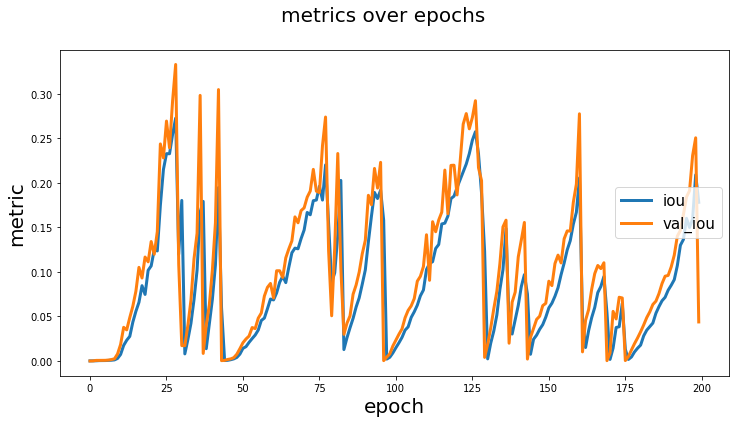

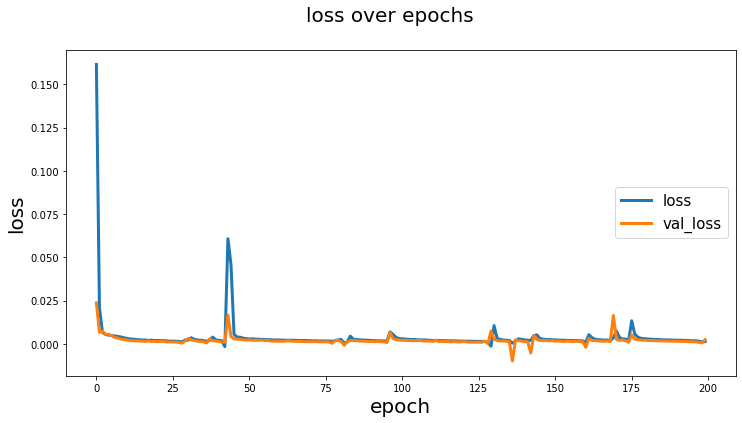

In [17]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [18]:
y_pred = model.predict(X_val)

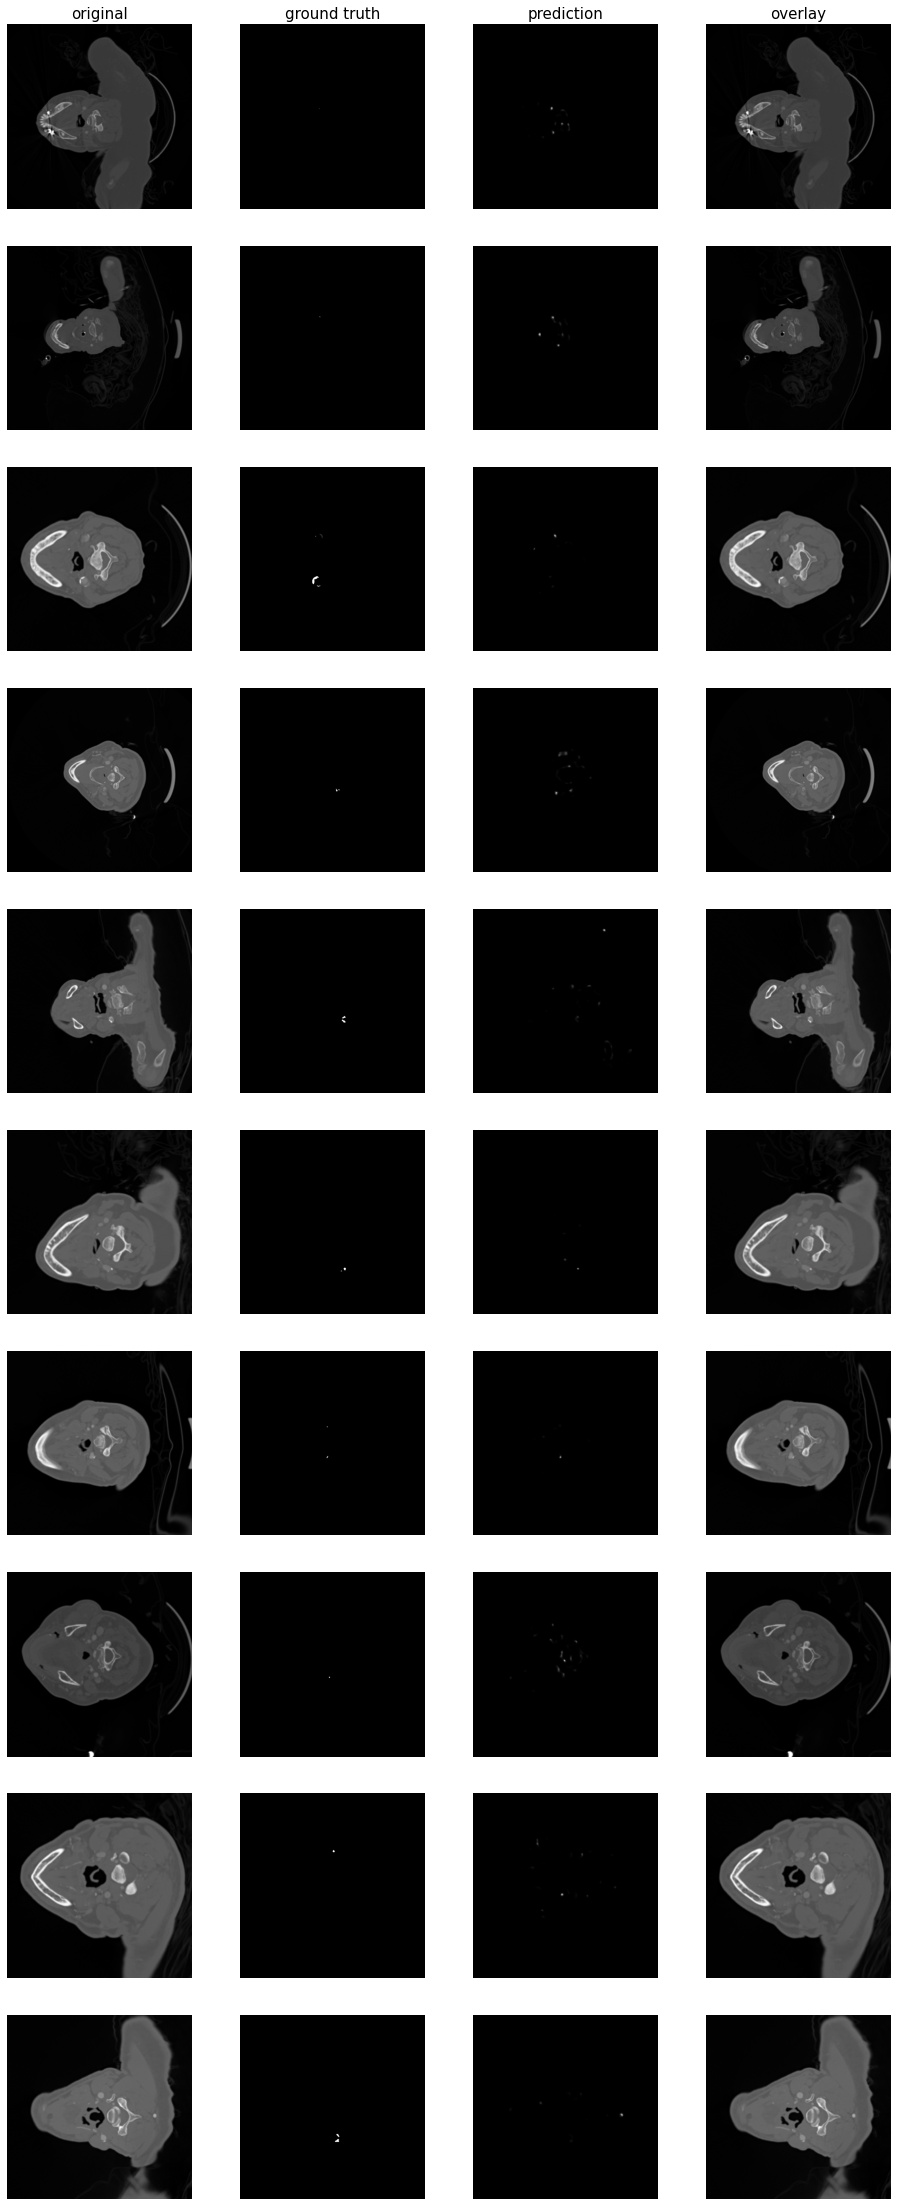

In [19]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [20]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

6/6 [==============================] - 0s 73ms/step - loss: 0.0024 - iou: 0.0438 - iou_thresholded: 0.0107
